# **Heartbeat sounds**

Heart sounds are produced from a
specific cardiac event such as closure of
a valve or tensing of a chordae
tendineae.

• S1 result from the closing of the mitral
and tricuspid valves.

• S2 produced by the closure of the aortic
and pulmonic valves. 

# About data: 

# Import main libraries

In [1]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf

from keras.utils import np_utils
from keras.layers.merge import concatenate
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [2]:
data_path = "../input/heartbeat-sound/Heartbeat_Sound/"
print(os.listdir(data_path))

['artifact', 'unlabel', 'extrastole', 'extrahls', 'normal', 'murmur']


In [3]:
tarin_data      = data_path 
unlabel_data    = data_path  + "/unlabel/"

normal_data     = tarin_data + '/normal/'
murmur_data     = tarin_data + '/murmur/'
extrastole_data = tarin_data + '/extrastole/'
artifact_data   = tarin_data + '/artifact/'
extrahls_data   = tarin_data + "/extrahls/"

In [4]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("Murmur files:",len(os.listdir(murmur_data))) #length of murmur training sounds 
print("Extrastole files", len(os.listdir(extrastole_data))) #length of extrastole training sounds 
print("Artifact files:",len(os.listdir(artifact_data))) #length of artifact training sounds 
print("Extrahls files:",len(os.listdir(extrahls_data))) #length of extrahls training sounds 

print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data)) 
                              + len(os.listdir(murmur_data))
                              + len(os.listdir(extrastole_data))
                              + len(os.listdir(artifact_data))
                              + len(os.listdir(extrahls_data)))

Normal files: 351
Murmur files: 129
Extrastole files 46
Artifact files: 40
Extrahls files: 19
TOTAL TRAIN SOUNDS: 585


In [5]:
print("No. of Sample for Test sounds: ", len(os.listdir(unlabel_data)))

No. of Sample for Test sounds:  247


# EDA and Visualization

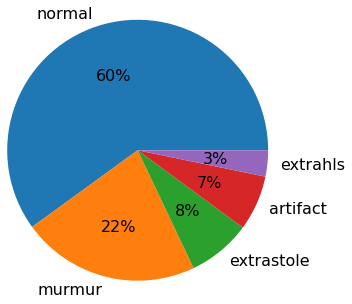

In [6]:
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(murmur_data)),
              len(os.listdir(extrastole_data)),
              len(os.listdir(artifact_data)),
              len(os.listdir(extrahls_data))])
labels = ['normal', 'murmur', 'extrastole', 'artifact', 'extrahls']
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show()

##### The figure shows imbalanced data so we need to fix it later 


In [7]:
# Listen to rondom audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class))) 
    sound = os.listdir(audio_class)[random_sound]
    sound = audio_class+sound
    sound,sample_rate = librosa.load(sound)
    return ipd.Audio(sound,rate=sample_rate),sound

In [8]:
# show waveform of audio from dataset 
# X axis, represents time.
# Y-axis measures displacement of air molecules.
# This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.  
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))
    librosa.display.waveplot(audio_sample, sr = 22050)
#     plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [9]:
# show spectrum of audio from dataset 
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal)) 
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

    plt.figure(figsize=(12,8))
    plt.plot(half_freq,half_magnitude)
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

In [10]:
# show specrogram of audio from dataset 
# the output is an image that represents a sound. 
# X-axis is for time, y-axis is for frequency and the color is for intensity
def show_spectrogram (audio_sample):    
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

### MFCCs

We can’t take the raw audio signal as input to our model because there will be a lot of noise in the audio signal. It is observed that extracting features from the audio signal and using it as input to the base model will produce much better performance than directly considering raw audio signal as input. MFCC is the widely used technique for extracting the features from the audio signal.

**MFCCs are commonly derived as follows:**

1- Take the Fourier transform of (a windowed excerpt of) a signal.

2- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.

3- Take the logs of the powers at each of the mel frequencies.

4- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.

5- The MFCCs are the amplitudes of the resulting spectrum.

In [11]:
# MFCCs
# extract 52 MFCCs
def show_mfcc_features(audio_sample):
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050
    
    MFCCs = librosa.feature.mfcc(audio_sample, n_fft=n_fft, hop_length=hop_length, n_mfcc=52)

    # display MFCCs
    plt.figure(figsize=(15,10))
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()

##  Dataset Classes

### *1. Normal* 

Most normal heart rates at rest
will be between about 60 and
100 beats (‘lub dub’s) per
minute. 

In [12]:
normal_audio, normal_sample  = random_sound(normal_data)
normal_audio

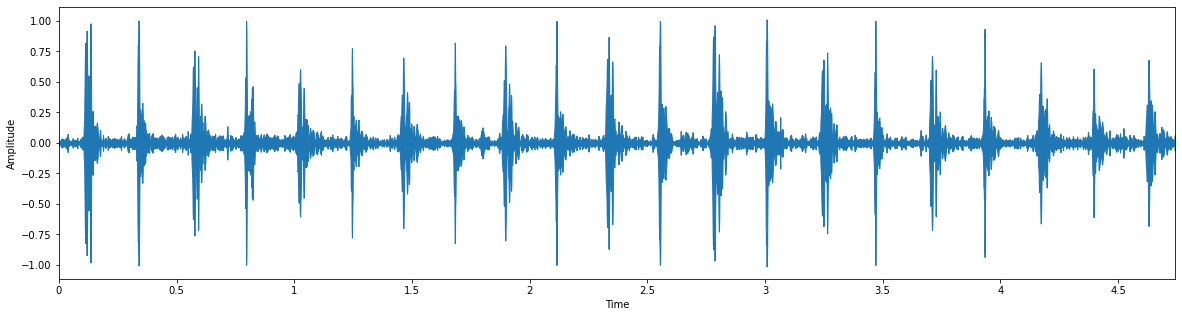

In [13]:
show_audio_waveform(normal_sample)

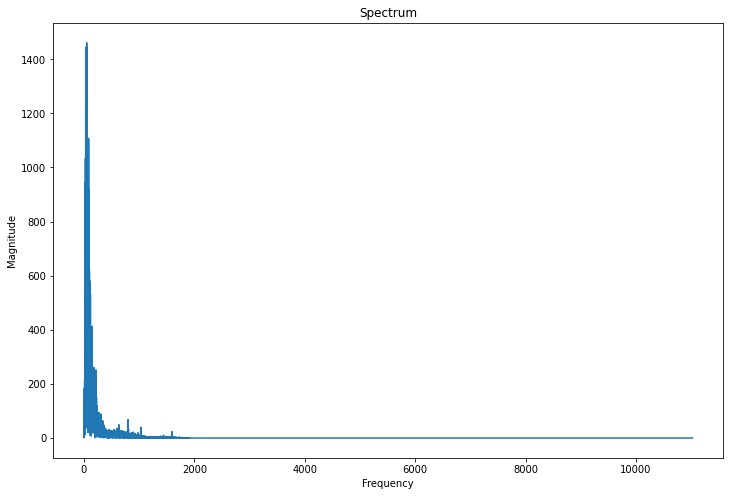

In [14]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


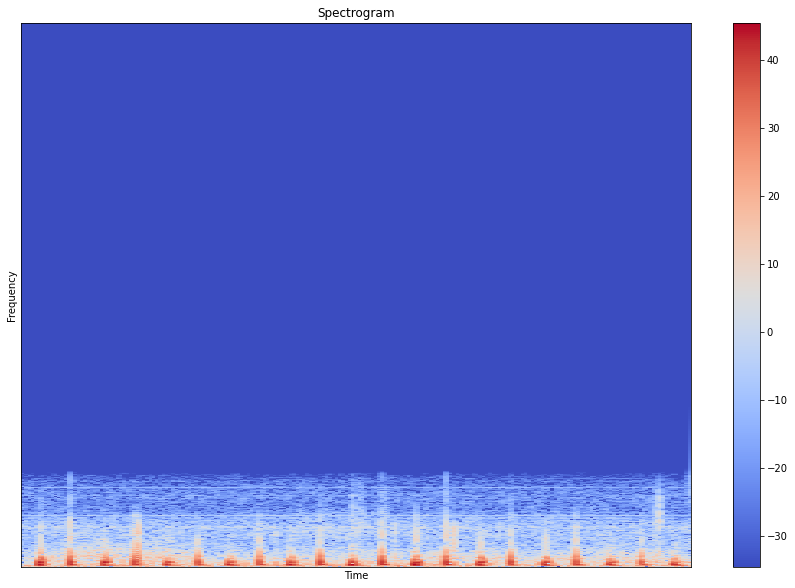

In [15]:
show_spectrogram(normal_sample)

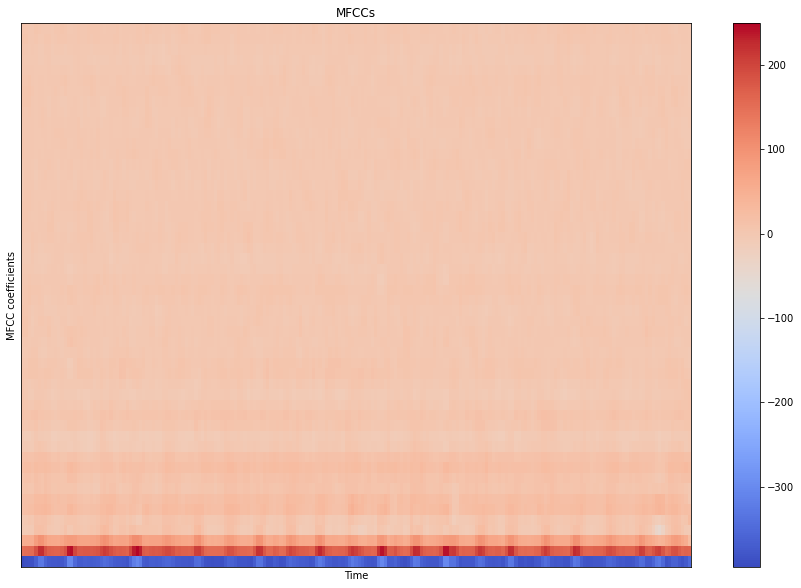

In [16]:
show_mfcc_features(normal_sample)

### *2. Murmur sound*

Heart murmurs sound as though there
is a “whooshing, roaring, rumbling, or
turbulent fluid” noise in one of two
temporal locations: (1) between “lub”
and “dub”, or (2) between “dub” and
“lub”. They can be a symptom of many
heart disorders, some serious. 

In [17]:
murmur_audio, murmur_sample  = random_sound(murmur_data)
murmur_audio

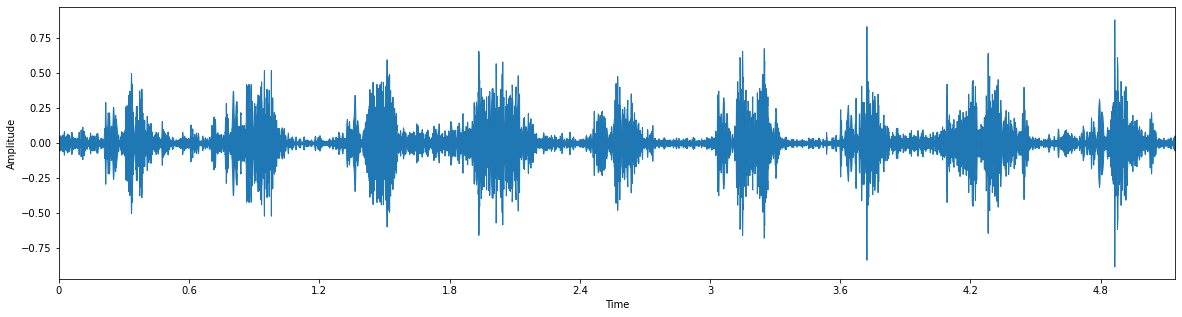

In [18]:
show_audio_waveform(murmur_sample)

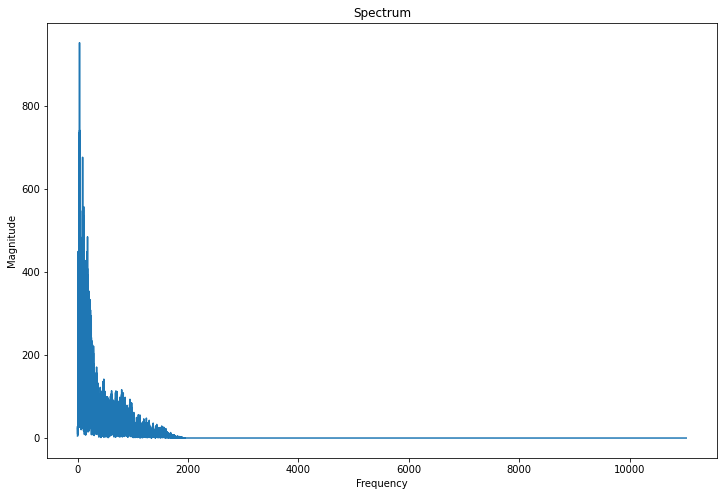

In [19]:
show_audio_spectrum(murmur_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


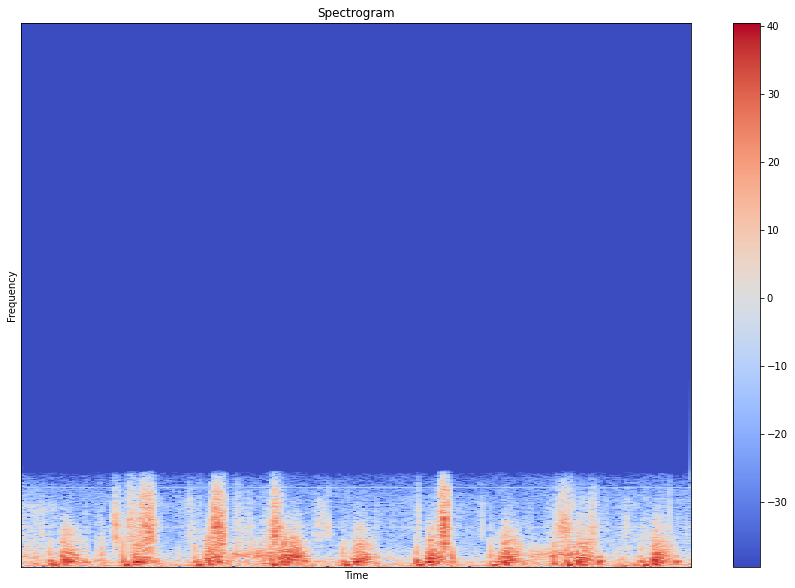

In [20]:
show_spectrogram(murmur_sample)

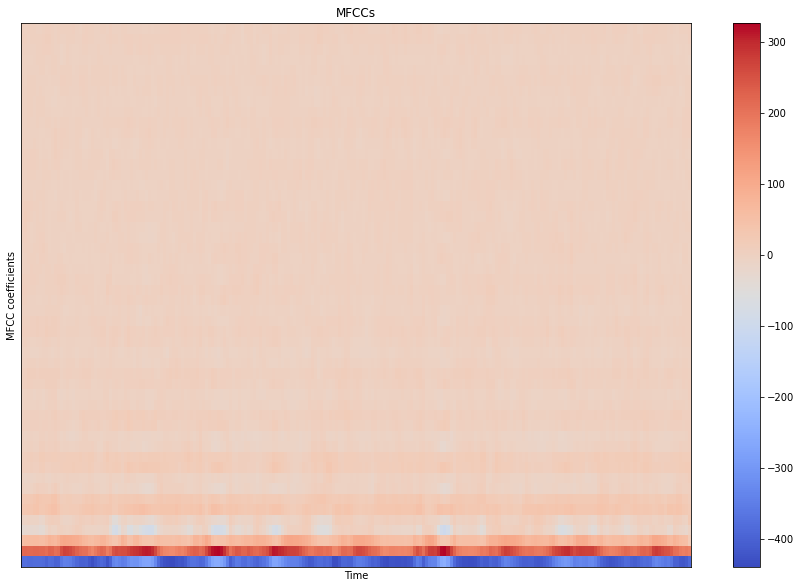

In [21]:
show_mfcc_features(murmur_sample)

### *3. Extrastole sound*

• Extrasystole sounds may appear occasionally and can be
identified because there is a heart sound that is out of rhythm
involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a
“lub dub-dub”.

In [22]:
extrastole_audio, extrastole_sample  = random_sound(extrastole_data)
extrastole_audio

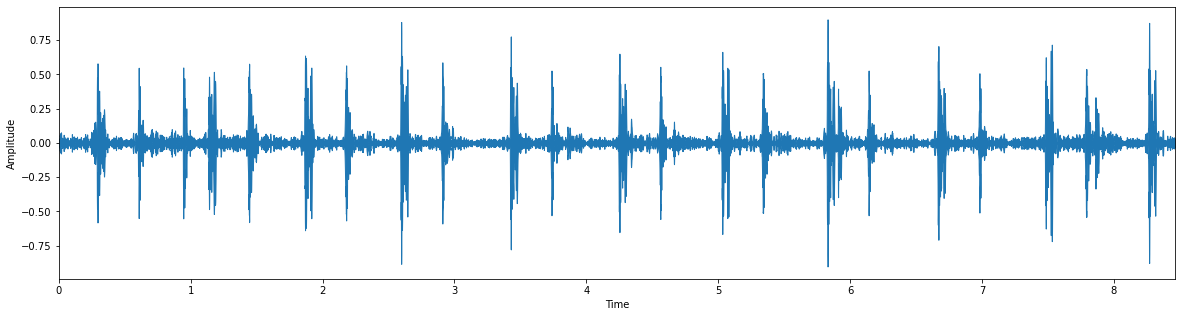

In [23]:
show_audio_waveform(extrastole_sample)

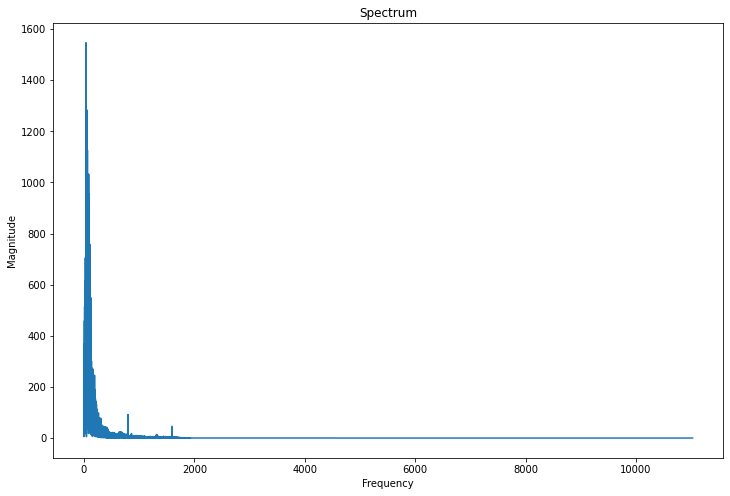

In [24]:
show_audio_spectrum(extrastole_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


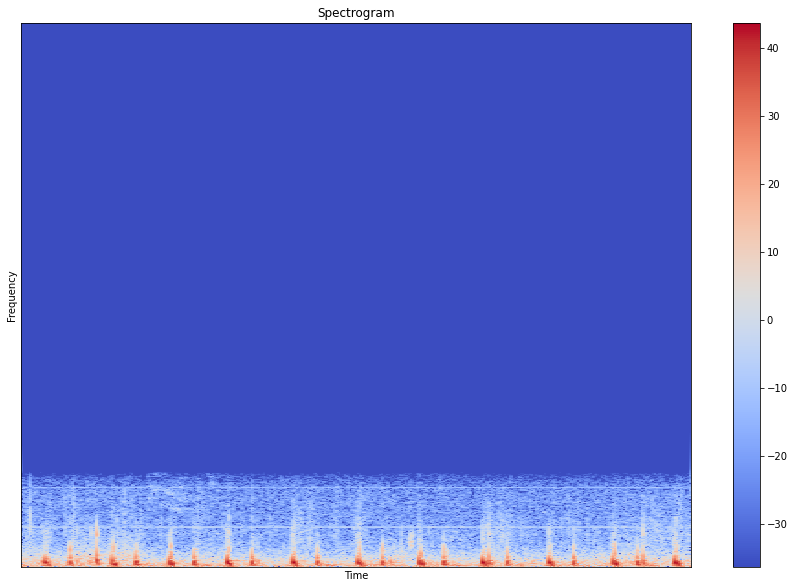

In [25]:
show_spectrogram(extrastole_sample)

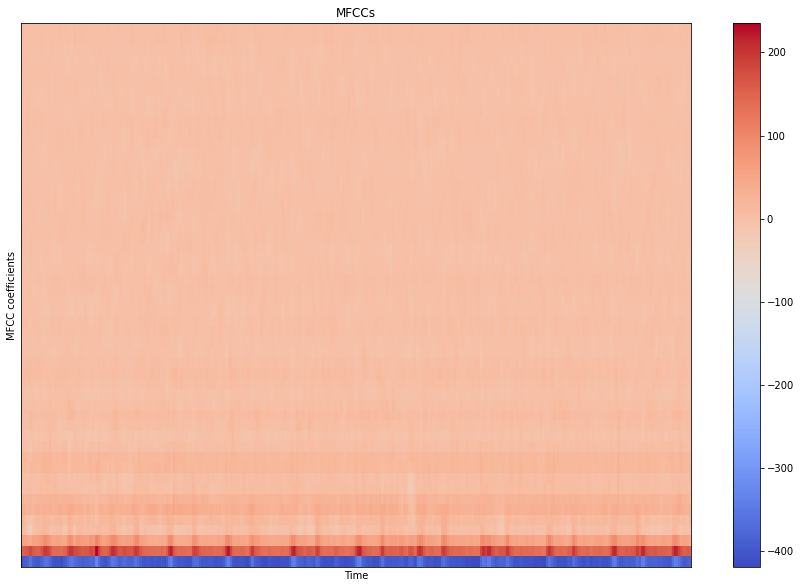

In [26]:
show_mfcc_features(extrastole_sample)

### *4. Artifact sound*

• In the Artifact category there are a wide range of different
sounds, including feedback squeals and echoes, speech, music
and noise.

In [27]:
artifact_audio, artifact_sample  = random_sound(artifact_data)
artifact_audio

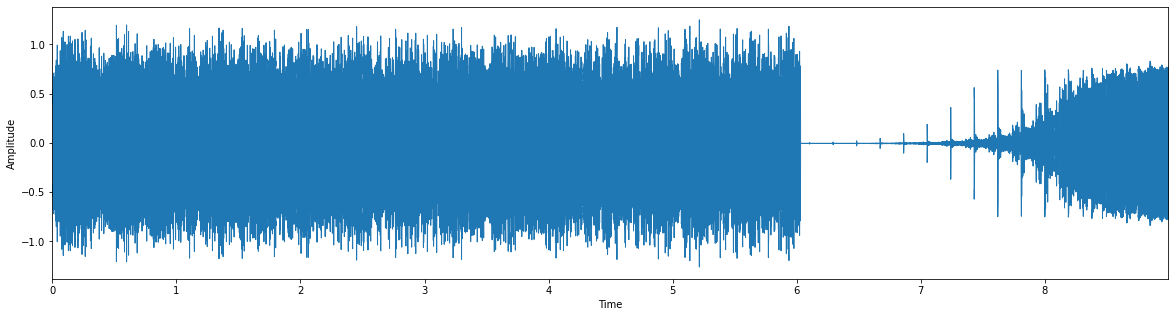

In [28]:
show_audio_waveform(artifact_sample)

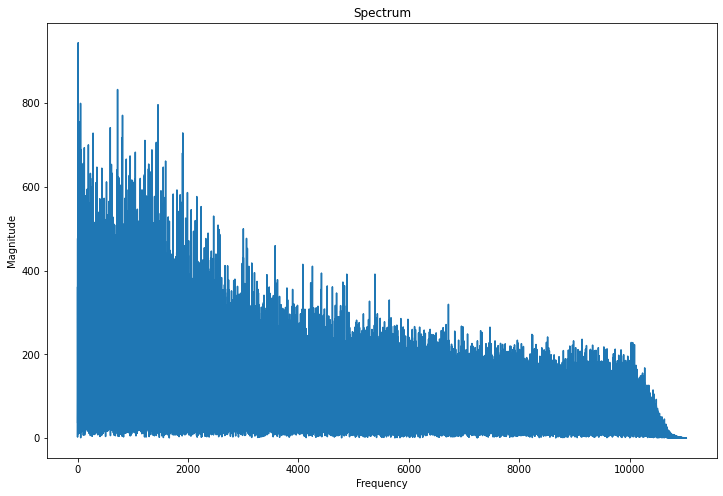

In [29]:
show_audio_spectrum(artifact_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


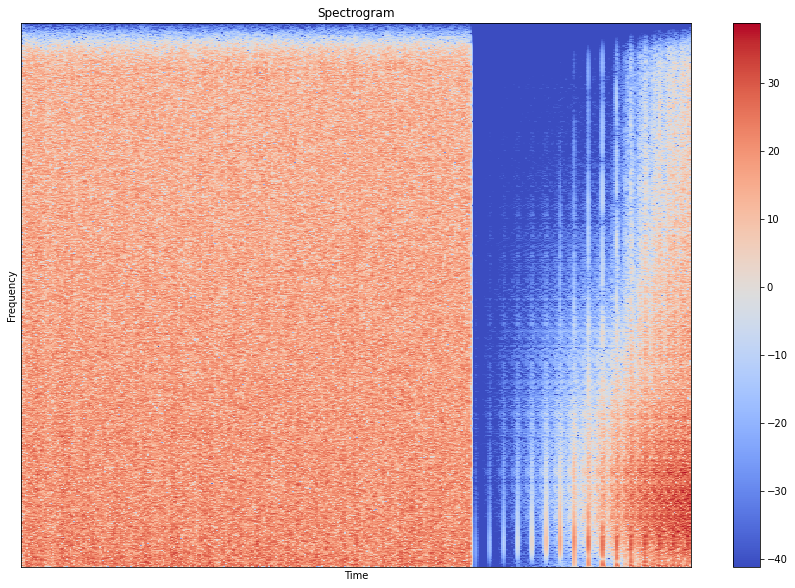

In [30]:
show_spectrogram(artifact_sample)

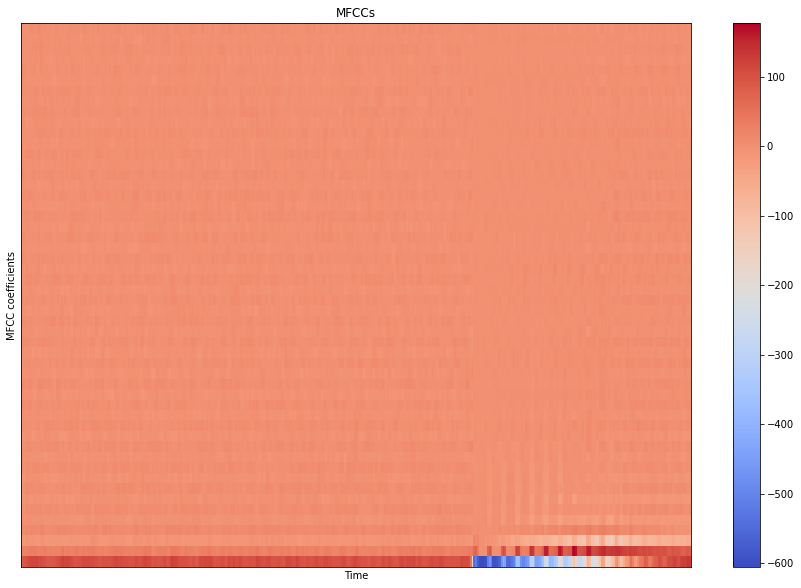

In [31]:
show_mfcc_features(artifact_sample)

### *5. Extrahls sound*

Extra heart sounds can be identified because there is an
additional sound, e.g. a “lub-lub dub” or a “lub dub-dub”. 

In [32]:
extrahls_audio, extrahls_sample  = random_sound(extrahls_data)
extrahls_audio

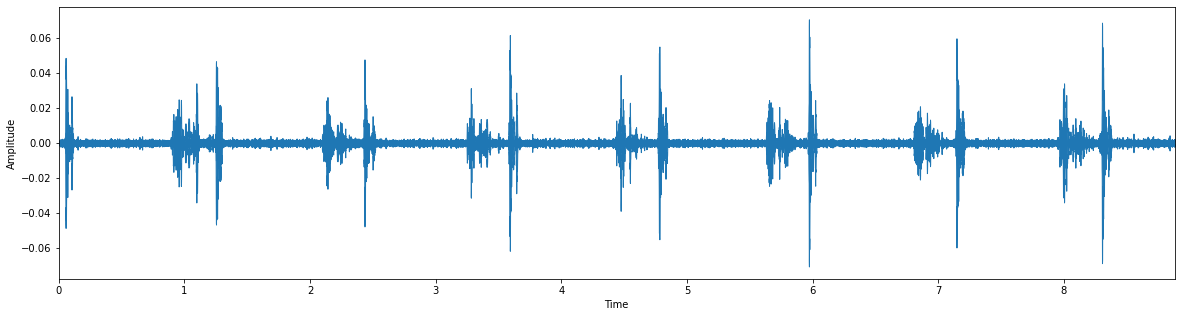

In [33]:
show_audio_waveform(extrahls_sample)

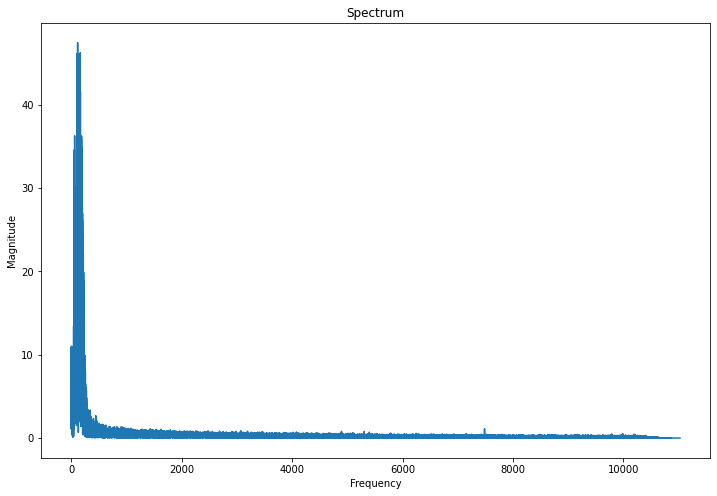

In [34]:
show_audio_spectrum(extrahls_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


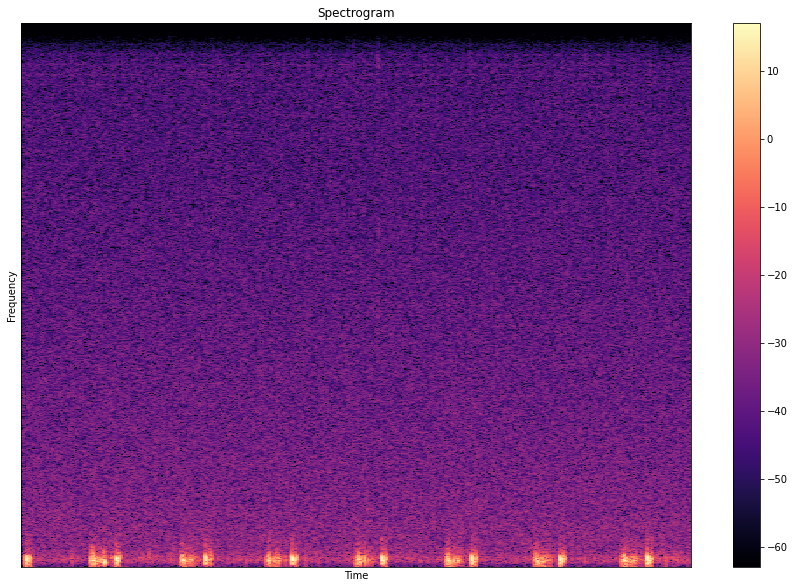

In [35]:
show_spectrogram(extrahls_sample)

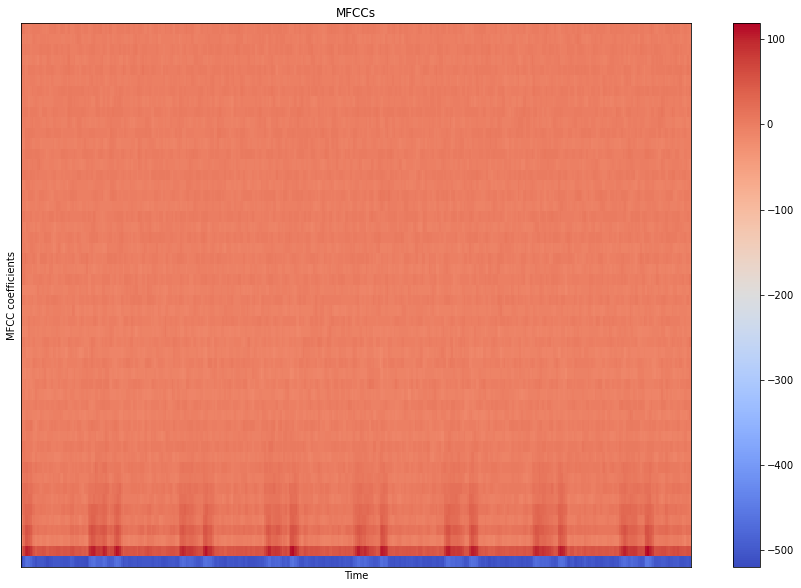

In [36]:
show_mfcc_features(extrahls_sample)

# Data Preprocessing

In [37]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [38]:
def load_file_data (folder, file_names, duration=10, sr=22050):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        52 features are extracted from each audio data and used to train the model.
    '''
        
     
    
    input_length=sr*duration
    features = 52
    data = []
    for file_name in file_names:
        try:
            sound_file = folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration) 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                X = librosa.util.fix_length(X, input_length)  
                
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=features).T,axis=0) 
            feature = np.array(mfccs).reshape([-1,1])
            data.append(feature)
            
            stretch_data_1 = stretch (X, 0.8)
            mfccs_stretch_1 = np.mean(librosa.feature.mfcc(y=stretch_data_1, sr=sr, n_mfcc=features).T,axis=0) 
            feature_1 = np.array(mfccs_stretch_1).reshape([-1,1])
            data.append(feature_1)
            
            stretch_data_2 = stretch (X, 1.2) 
            mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=stretch_data_2, sr=sr, n_mfcc=features).T,axis=0) 
            feature_2 = np.array(mfccs_stretch_2).reshape([-1,1])
            data.append(feature_2)
            
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        
    return data

## Encoding

In [39]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact


CLASSES = ['artifact','murmur','normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


## Data Augmenation and Feature Extraction

In [40]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

artifact_files = fnmatch.filter(os.listdir(artifact_data), 'artifact*.wav')
artifact_sounds = load_file_data (folder=artifact_data, file_names = artifact_files, duration=MAX_SOUND_CLIP_DURATION)
artifact_labels = [0 for items in artifact_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), 'normal*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]

extrahls_files = fnmatch.filter(os.listdir(extrahls_data), 'extrahls*.wav')
extrahls_sounds = load_file_data(folder=extrahls_data,file_names=extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
extrahls_labels = [2 for items in extrahls_sounds]

murmur_files = fnmatch.filter(os.listdir(murmur_data), 'murmur*.wav')
murmur_sounds = load_file_data(folder=murmur_data,file_names=murmur_files, duration=MAX_SOUND_CLIP_DURATION)
murmur_labels = [1 for items in murmur_sounds]


extrastole_files = fnmatch.filter(os.listdir(extrastole_data), 'extrastole*.wav')
extrastole_sounds = load_file_data(folder=extrastole_data,file_names=extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
extrastole_labels = [2 for items in extrastole_sounds]

print ("Loading Done")


fixing audio lenght : artifact__201106131834.wav
fixing audio lenght : artifact__201106101955.wav
fixing audio lenght : artifact__201106220340.wav
fixing audio lenght : artifact__201105190800.wav
fixing audio lenght : artifact__201106040722.wav
fixing audio lenght : artifact__201106070949.wav
fixing audio lenght : artifact__201106221254.wav
fixing audio lenght : artifact__201106010602.wav
fixing audio lenght : artifact__201106021541.wav
fixing audio lenght : artifact__201106010559.wav
fixing audio lenght : artifact__201105061143.wav
fixing audio lenght : artifact__201106110909.wav
fixing audio lenght : artifact__201106161219.wav
fixing audio lenght : artifact__201105040918.wav
fixing audio lenght : artifact__201106211041.wav
fixing audio lenght : artifact__201106211430.wav
fixing audio lenght : artifact__201105280851.wav
fixing audio lenght : artifact__201105051017.wav
fixing audio lenght : artifact__201106131835.wav
fixing audio lenght : artifact__201106050353.wav
fixing audio lenght 

In [41]:
# unlabel_data files conversion
Bunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Bunlabelledtest*.wav')
Bunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Bunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Bunlabelledtest_labels = [-1 for items in Bunlabelledtest_sounds]

Aunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Aunlabelledtest*.wav')
Aunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Aunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Aunlabelledtest_labels = [-1 for items in Aunlabelledtest_sounds]


print ("Loading of unlabel data done")


fixing audio lenght : Bunlabelledtest__231_1308748318393_C.wav
fixing audio lenght : Bunlabelledtest__152_1306779561195_C.wav
fixing audio lenght : Bunlabelledtest__235_1308749032454_C1.wav
fixing audio lenght : Bunlabelledtest__107_1305654946865_B.wav
fixing audio lenght : Bunlabelledtest__148_1306768801551_D.wav
fixing audio lenght : Bunlabelledtest__171_1307971016233_F.wav
fixing audio lenght : Bunlabelledtest__169_1307970398039_C1.wav
fixing audio lenght : Bunlabelledtest__148_1306768801551_A.wav
fixing audio lenght : Bunlabelledtest__179_1307990076841_D1.wav
fixing audio lenght : Bunlabelledtest__159_1307018640315_C.wav
fixing audio lenght : Bunlabelledtest__300_1311772096120_D.wav
fixing audio lenght : Bunlabelledtest__151_1306779785624_A1.wav
fixing audio lenght : Bunlabelledtest__181_1308052613891_C.wav
fixing audio lenght : Bunlabelledtest__174_1307987737137_C.wav
fixing audio lenght : Bunlabelledtest__286_1311170606028_B.wav
fixing audio lenght : Bunlabelledtest__175_13079879

## Concatenation

In [42]:
#combine set-a and set-b 
x_data = np.concatenate((artifact_sounds, normal_sounds,extrahls_sounds,murmur_sounds,extrastole_sounds))
print(x_data)
y_data = np.concatenate((artifact_labels, normal_labels,extrahls_labels,murmur_labels,extrastole_labels))

test_x = np.concatenate((Aunlabelledtest_sounds,Bunlabelledtest_sounds))
test_y = np.concatenate((Aunlabelledtest_labels,Bunlabelledtest_labels))

print ("combined training data record: ",len(x_data), len(test_x))

[[[-3.40292053e+02]
  [ 1.31745560e+02]
  [ 2.89621391e+01]
  ...
  [ 3.16183835e-01]
  [-4.91125613e-01]
  [-6.36102438e-01]]

 [[-3.52169678e+02]
  [ 1.22120880e+02]
  [ 3.10026417e+01]
  ...
  [-5.31147979e-02]
  [-8.96321535e-01]
  [-1.15266137e-01]]

 [[-3.54360382e+02]
  [ 1.29815430e+02]
  [ 3.05948925e+01]
  ...
  [ 1.83130540e-02]
  [-1.31864154e+00]
  [-6.76173806e-01]]

 ...

 [[-4.09144836e+02]
  [ 9.89138718e+01]
  [ 3.90294380e+01]
  ...
  [-6.19691372e-01]
  [ 2.71625698e-01]
  [ 2.90518343e-01]]

 [[-4.32297424e+02]
  [ 9.59234848e+01]
  [ 4.02707481e+01]
  ...
  [-8.64639163e-01]
  [ 3.65361311e-02]
  [ 2.60697812e-01]]

 [[-4.44941559e+02]
  [ 1.02441124e+02]
  [ 4.15524025e+01]
  ...
  [-9.18059647e-01]
  [ 2.54658103e-01]
  [ 3.98600131e-01]]]
combined training data record:  1755 741


## Data Split


In [43]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42, shuffle=True)

# One-Hot Encoding

y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

## Correct Imbalanced Data

In [44]:
# class weight 

TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #artifact
COUNT_1 = 129 #murmur
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

# LSTM Model

In [45]:
x_train_lstm = x_train
x_val_lstm = x_test
x_test_lstm = x_val

y_train_lstm = y_train
y_val_lstm = y_test
y_test_lstm = y_val

## Build Model

In [46]:
lstm_model = Sequential()

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(128))


lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(3, activation='softmax')) #3 beacuse it's a 3 class classification

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 52, 1024)          6144      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 1024)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 1024)          4096      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 512)           2621952   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 512)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 512)           2048      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 256)           6

In [47]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cb = [EarlyStopping(patience=15,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/Heart_LSTM_CNN_umak.h5",save_best_only=True)]

## Train Model

In [48]:
history = lstm_model.fit(x_train_lstm, y_train_lstm, 
                         validation_data=(x_val_lstm, y_val_lstm),
                         batch_size=8, epochs=150, 
                         class_weight=class_weight,callbacks = cb )

Epoch 1/150
158/158 [==============================] - 14s 17ms/step - loss: 0.8609 - accuracy: 0.5218 - val_loss: 0.9261 - val_accuracy: 0.4330
Epoch 2/150
158/158 [==============================] - 2s 11ms/step - loss: 0.6619 - accuracy: 0.5843 - val_loss: 0.7822 - val_accuracy: 0.6724
Epoch 3/150
158/158 [==============================] - 2s 11ms/step - loss: 0.6032 - accuracy: 0.5930 - val_loss: 0.8371 - val_accuracy: 0.5613
Epoch 4/150
158/158 [==============================] - 2s 11ms/step - loss: 0.5626 - accuracy: 0.6722 - val_loss: 1.5603 - val_accuracy: 0.3675
Epoch 5/150
158/158 [==============================] - 2s 11ms/step - loss: 0.5063 - accuracy: 0.6754 - val_loss: 0.7051 - val_accuracy: 0.7692
Epoch 6/150
158/158 [==============================] - 2s 11ms/step - loss: 0.5131 - accuracy: 0.6873 - val_loss: 0.8537 - val_accuracy: 0.4729
Epoch 7/150
158/158 [==============================] - 2s 11ms/step - loss: 0.5139 - accuracy: 0.6793 - val_loss: 0.5055 - val_accuracy

## Evaluate Model

In [49]:
lstm_model.evaluate(x_val_lstm, y_val_lstm)

11/11 [==============================] - 0s 8ms/step - loss: 0.1731 - accuracy: 0.9430


[0.1730741560459137, 0.9430199265480042]

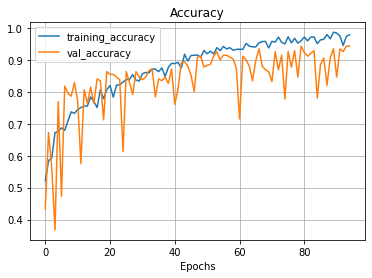

In [50]:
def plot_loss_curves(history):
    
  """
  Returns separate loss curves for training and validation metrics.
  
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  

  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

## Results

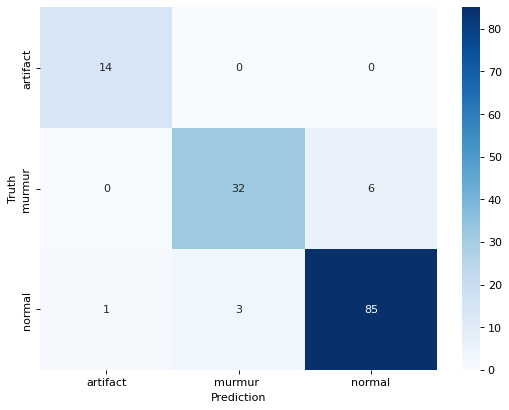

In [51]:

classes = ["artifact" ,"murmur ", "normal"]

preds = lstm_model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_lstm]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [52]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

    artifact       0.93      1.00      0.97        14
     murmur        0.91      0.84      0.88        38
      normal       0.93      0.96      0.94        89

    accuracy                           0.93       141
   macro avg       0.93      0.93      0.93       141
weighted avg       0.93      0.93      0.93       141



## Prediction 

In [53]:
def heart_prediction (file_path, duration=10, sr=22050):
    classes=["artifact","murmur","normal"]
    input_length=sr*duration
    
    X, sr = librosa.load(file_path, sr=sr, duration=duration) 
    dur = librosa.get_duration(y=X, sr=sr)
    
    # pad audio file same duration
    if (round(dur) < duration):
        X = librosa.util.fix_length(X, input_length)
        
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=52, n_fft=512,hop_length=2048).T,axis=0)
    feature = np.array(mfccs).reshape([-1,1])
    
    preds=lstm_model.predict(mfccs.reshape(1,52,1))
    preds=classes [np.argmax(preds)]
    confidence = np.amax(preds)
    return preds, confidence 